In [330]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [331]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.utils import define_device
import pandas as pd
import numpy as np
np.random.seed(0)


import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [332]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Crossmatch.csv')


In [333]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [334]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingCrossmatch.csv')

In [335]:
train.head()

,Filename,White Circular Patch,Contrast,Black Patch,Biffurcation,Termination,CID,Class,OCL_STD,LCS_STD,...,LCS,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2
0,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,30776.0,0.010333,0.999772,3804,333,107.771544,1,0.183448,0.321274,...,0.548794,0.613218,0.616894,0.125473,0.132002,0.325032,0.041322,0.355333,0.208121,0.006742
1,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,40066.5,0.003752,0.999955,5288,616,156.874296,1,0.149823,0.288940,...,0.549479,0.577886,0.515961,0.151181,0.125693,0.246866,0.056600,0.320952,0.221123,0.008132
2,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,49524.0,0.004532,0.999884,4861,361,218.001356,1,0.157811,0.320884,...,0.501499,0.532120,0.626022,0.130306,0.118022,0.269136,0.065313,0.317784,0.267345,0.007559
3,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,10324.0,0.047750,0.998029,1661,337,212.954369,1,0.143613,0.323289,...,0.519335,0.341780,0.591813,0.066328,0.097421,0.292708,0.045235,0.315834,0.116780,0.003814
4,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,11792.0,0.029279,0.999124,2026,347,181.324385,1,0.163183,0.324478,...,0.511962,0.477842,0.595702,0.074459,0.149858,0.316726,0.039893,0.328637,0.120669,0.004112


In [336]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))    
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [337]:
train["Set"]

0       train
1       train
2       train
3       train
4       train
        ...  
2972    train
2973    train
2974    train
2975    train
2976    train
Name: Set, Length: 2977, dtype: object

In [338]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Filename 2977
Class 2
Set 2


In [339]:
categorical_columns

['Filename', 'Class', 'Set']

In [340]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,LCS,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2
0,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,5292.0,0.166200,0.976471,1509,403,332.053514,1,0.082090,0.160900,...,0.816128,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765
1,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,4175.5,0.098199,0.989966,1339,453,265.142266,1,0.075764,0.141661,...,0.818791,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077
2,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,5829.0,0.054095,0.996549,1679,472,293.976355,1,0.096840,0.210623,...,0.782909,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679
3,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,3193.5,0.024822,0.998801,1902,340,289.341544,1,0.119394,0.230169,...,0.761932,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148
4,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,3132.0,0.129463,0.985666,1132,296,314.832926,1,0.129622,0.254241,...,0.756784,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812


In [341]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [342]:
test_indices

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940],
           dtype='int64', length=2941)

In [343]:
nunique = test.nunique()
types = test.dtypes


for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Filename 2941
Class 2
Set 1


In [344]:
categorical_columns

['Filename', 'Class', 'Set']

In [345]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,1,0.082090,0.160900,...,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,1,0.075764,0.141661,...,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,1,0.096840,0.210623,...,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,1,0.119394,0.230169,...,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,1,0.129622,0.254241,...,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812,0


In [346]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,1,0.082090,0.160900,...,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,1,0.075764,0.141661,...,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,1,0.096840,0.210623,...,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,1,0.119394,0.230169,...,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,1,0.129622,0.254241,...,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812,0


In [347]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"

In [348]:
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [349]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [350]:
cat_dims

[2977]

In [351]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [352]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

In [353]:
test.rename(columns={'White Circle Patch': 'White Circular Patch', 'Biffercation': 'Biffurcation','MEAN': 'MU'}, inplace=True)

In [354]:
X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]

In [355]:
test.head()

,Filename,White Circular Patch,Contrast,Black Patch,Biffurcation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,classOne,0.082090,0.160900,...,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,classOne,0.075764,0.141661,...,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,classOne,0.096840,0.210623,...,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,classOne,0.119394,0.230169,...,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,classOne,0.129622,0.254241,...,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812,0


In [356]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [357]:
class ClassificationSMOTE():
    """
    Apply SMOTE for classification tasks.
    This will average a percentage p of the elements in the batch with other elements.
    The target will stay unchanged and keep the value of the most important row in the mix.
    """
    def __init__(self, device_name="auto", p=0.8, alpha=0.5, beta=0.5, seed=0):
        ""
        self.seed = seed
        self._set_seed()
        self.device = define_device(device_name)
        self.alpha = alpha
        self.beta = beta
        self.p = p
        if (p < 0.) or (p > 1.0):
            raise ValueError("Value of p should be between 0. and 1.")

    def _set_seed(self):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        return

    def __call__(self, X, y):
        batch_size = X.shape[0]
        random_values = torch.rand(batch_size, device=self.device)
        idx_to_change = random_values < self.p

        # ensure that first element to switch has probability > 0.5
        np_betas = np.random.beta(self.alpha, self.beta, batch_size) / 2 + 0.5
        random_betas = torch.from_numpy(np_betas).to(self.device).float()
        index_permute = torch.randperm(batch_size, device=self.device)

        X[idx_to_change] = random_betas[idx_to_change, None] * X[idx_to_change]
        X[idx_to_change] += (1 - random_betas[idx_to_change, None]) * X[index_permute][idx_to_change].view(X[idx_to_change].size())  # noqa

        return X, y

In [358]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [359]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug,#aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.81351 | train_auc: 0.47546 | valid_auc: 0.4825  |  0:00:00s
epoch 1  | loss: 0.50138 | train_auc: 0.49826 | valid_auc: 0.49837 |  0:00:00s
epoch 2  | loss: 0.43604 | train_auc: 0.48256 | valid_auc: 0.48574 |  0:00:00s
epoch 3  | loss: 0.37668 | train_auc: 0.37149 | valid_auc: 0.33758 |  0:00:00s
epoch 4  | loss: 0.3434  | train_auc: 0.47797 | valid_auc: 0.42973 |  0:00:01s
epoch 5  | loss: 0.29366 | train_auc: 0.69568 | valid_auc: 0.65774 |  0:00:01s
epoch 6  | loss: 0.2724  | train_auc: 0.83964 | valid_auc: 0.80571 |  0:00:01s
epoch 7  | loss: 0.25973 | train_auc: 0.90395 | valid_auc: 0.88134 |  0:00:01s
epoch 8  | loss: 0.22621 | train_auc: 0.87032 | valid_auc: 0.86648 |  0:00:01s
epoch 9  | loss: 0.23798 | train_auc: 0.87843 | valid_auc: 0.86759 |  0:00:02s
epoch 10 | loss: 0.20755 | train_auc: 0.85132 | valid_auc: 0.83972 |  0:00:02s
epoch 11 | loss: 0.19437 | train_auc: 0.89436 | valid_auc: 0.88638 |  0:00:02s
epoch 12 | loss: 0.19785 | train_auc: 0.90776 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.81351 | train_auc: 0.47546 | valid_auc: 0.4825  |  0:00:00s
epoch 1  | loss: 0.50138 | train_auc: 0.49826 | valid_auc: 0.49837 |  0:00:00s
epoch 2  | loss: 0.43604 | train_auc: 0.48256 | valid_auc: 0.48574 |  0:00:00s
epoch 3  | loss: 0.37668 | train_auc: 0.37149 | valid_auc: 0.33758 |  0:00:00s
epoch 4  | loss: 0.3434  | train_auc: 0.47797 | valid_auc: 0.42973 |  0:00:00s
epoch 5  | loss: 0.29366 | train_auc: 0.69568 | valid_auc: 0.65774 |  0:00:01s
epoch 6  | loss: 0.2724  | train_auc: 0.83964 | valid_auc: 0.80571 |  0:00:01s
epoch 7  | loss: 0.25973 | train_auc: 0.90395 | valid_auc: 0.88134 |  0:00:01s
epoch 8  | loss: 0.22621 | train_auc: 0.87032 | valid_auc: 0.86648 |  0:00:01s
epoch 9  | loss: 0.23798 | train_auc: 0.87843 | valid_auc: 0.86759 |  0:00:01s
epoch 10 | loss: 0.20755 | train_auc: 0.85132 | valid_auc: 0.83972 |  0:00:02s
epoch 11 | loss: 0.19437 | train_auc: 0.89436 | valid_auc: 0.88638 |  0:00:02s
epoch 12 | loss: 0.19785 | train_auc: 0.90776 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


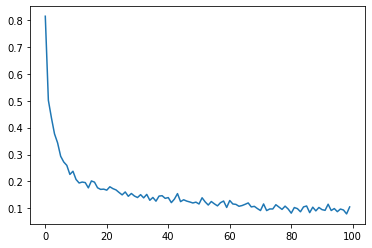

In [360]:
plt.plot(clf.history['loss'])

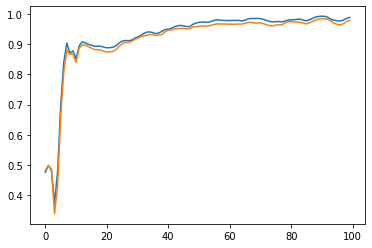

In [361]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

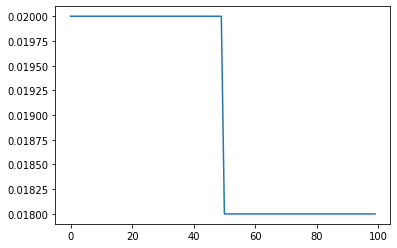

In [362]:
plt.plot(clf.history['lr'])

In [363]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.9848834152358995
FINAL TEST SCORE : 0.9749053253726151


In [364]:
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [365]:
clf.predict(X_test)

array(['classZero', 'classZero', 'classOne', ..., 'classZero',
       'classZero', 'classZero'], dtype='<U9')

In [366]:

saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [367]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [368]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.9749053253726151


In [369]:
assert(test_auc == loaded_test_auc)

In [370]:
loaded_clf.predict(X_test)

array(['classZero', 'classZero', 'classOne', ..., 'classZero',
       'classZero', 'classZero'], dtype='<U9')

In [371]:
clf.feature_importances_

array([0.04649551, 0.00390387, 0.06139185, 0.00539903, 0.14981975,
       0.01699773, 0.11064008, 0.03606804, 0.00130057, 0.01305726,
       0.03225595, 0.05550121, 0.04061767, 0.01128237, 0.01739304,
       0.15776014, 0.00906424, 0.03758221, 0.0284317 , 0.02136708,
       0.00888869, 0.00596731, 0.00853639, 0.01950517, 0.00049642,
       0.01939533, 0.02930385, 0.05157755])

In [372]:
explain_matrix, masks = clf.explain(X_test)

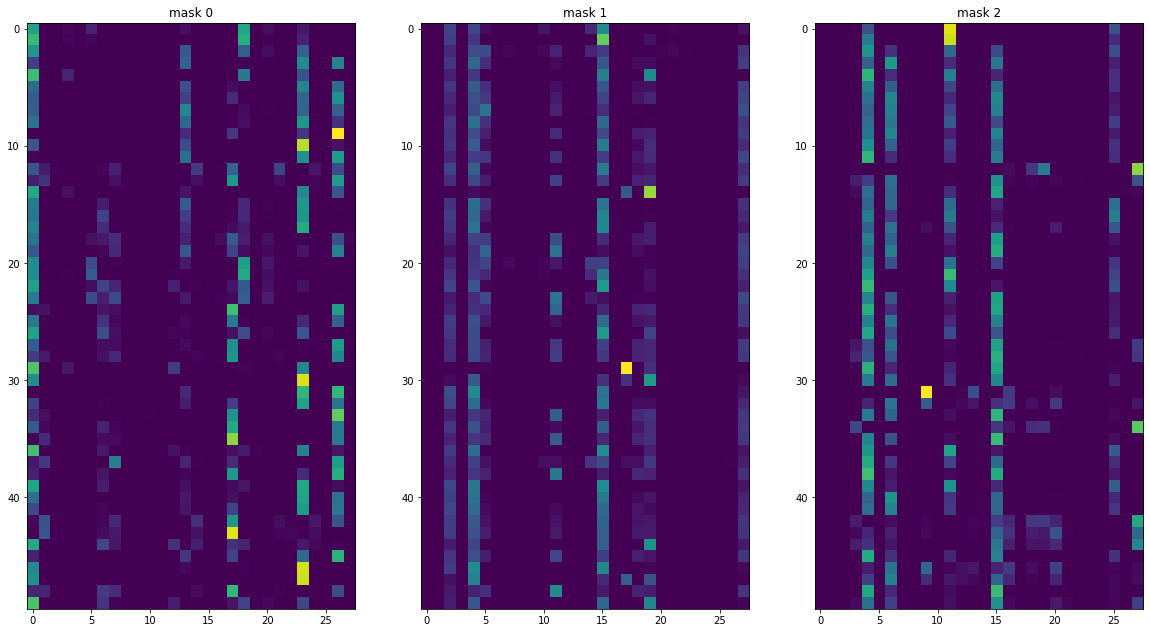

In [373]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")